# XAI Taxonomie - Datenanalyse

In [1]:
!pip install kmodes

In [1]:
import pandas as pd
import math 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import chi2_contingency

&emsp;

&emsp;

**Importieren der Daten**

In [2]:
xai = pd.read_csv('xai-table.csv')
xai.head()

,Name,Zeitpunkt,Anwendbarkeit,Beschraenkung,Ebene,Funktionsweise,Erklaerbarkeit
0,Causal Models,Ante-hoc,-,-,Lokal,Entwicklungsbegleitend,Antworten mit Begruendung
1,TEVM,Ante-hoc,-,-,Lokal,Entwicklungsbegleitend,Antworten mit Begruendung
2,SISTA,Ante-hoc,-,-,Global,Entwicklungsbegleitend,Intrinsisch
3,Whitebox Models,Ante-hoc,-,-,Global,Entwicklungsbegleitend,Intrinsisch
4,X-NeSyL,Ante-hoc,-,-,Global,Entwicklungsbegleitend,Intrinsisch


&emsp;

&emsp;

**Definieren der Normalisierungsfunktion**

In [3]:
def normalize(array):
    min_value = np.min(array)
    max_value = np.max(array)
    norm_array = []
    for x in array:
        norm_value = (x - min_value) / (max_value - min_value)
        norm_array.append(norm_value)
    return norm_array

&emsp;

&emsp;

**Ausehen der Features**

Zunächst lohnt sich ein genauerer Blick auf die einzelnen Werte

In [4]:
def getUniqueCount(frame, feature):
    array = frame[feature].unique()
    count = 0
    for x in array:
        if x != '-':
            count = count + 1
    return count

def getUniqueValues(frame, feature):
    array = frame[feature].unique()
    string = ""
    for x in array:
        if x != '-':
          string = string + x + ', '
    return [feature, string[:-2], getUniqueCount(frame, feature)]

def getAllUniqueValues(frame):
    features = list(frame)
    alluniqueValues = []
    for x in features:
      alluniqueValues.append(getUniqueValues(frame, x))
    return alluniqueValues

In [15]:
xai_features = xai[['Zeitpunkt', 'Anwendbarkeit', 'Beschraenkung', 'Funktionsweise', 'Ebene', 'Erklaerbarkeit']]

feature_values = pd.DataFrame(getAllUniqueValues(xai_features))
feature_values.columns = ['Merkmal', 'Kategorien', 'Anzahl']
feature_values['Anzahl (normiert)'] = normalize(np.array(feature_values['Anzahl']))
feature_values.sort_values(by=['Anzahl'], inplace=True, ascending=True)
feature_values

,Merkmal,Kategorien,Anzahl,Anzahl (normiert)
0,Zeitpunkt,"Ante-hoc, Post-hoc",2,0.000000
1,Anwendbarkeit,"Modell-agnostisch, Modell-spezifisch",2,0.000000
4,Ebene,"Lokal, Global",2,0.000000
2,Beschraenkung,"Keine, ANN, CNN, RNN, GNN, RF, SVM",7,0.833333
5,Erklaerbarkeit,"Antworten mit Begruendung, Intrinsisch, Featur...",7,0.833333
3,Funktionsweise,"Entwicklungsbegleitend, Berechnung der Feature...",8,1.000000


&emsp;

&emsp;

**Berechnen der Carmers Vs für die Features**

Den Code habe ich aus diesem Repo: https://github.com/Sakil786/Correlation_between_two_categorical_variables

In [16]:
def cramers_V(var1,var2):
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab, correction=False)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape)-1
  return math.sqrt(stat/(obs*mini))

In [17]:
xai_features = xai[['Zeitpunkt', 'Ebene', 'Anwendbarkeit', 'Beschraenkung', 'Funktionsweise', 'Erklaerbarkeit']]

rows= []
for var1 in xai_features:
  col = []
  for var2 in xai_features :
    cramers =cramers_V(xai_features[var1], xai_features[var2])
    col.append(round(cramers,2))
  rows.append(col)
  
cramers_results = np.array(rows)
cramers_v_values = pd.DataFrame(cramers_results, columns = xai_features.columns, index =xai_features.columns)
cramers_v_values

,Zeitpunkt,Ebene,Anwendbarkeit,Beschraenkung,Funktionsweise,Erklaerbarkeit
Zeitpunkt,1.00,0.32,1.00,1.00,1.00,0.69
Ebene,0.32,1.00,0.32,0.44,0.64,0.77
Anwendbarkeit,1.00,0.32,1.00,1.00,0.79,0.63
Beschraenkung,1.00,0.44,1.00,1.00,0.57,0.51
Funktionsweise,1.00,0.64,0.79,0.57,1.00,0.78
Erklaerbarkeit,0.69,0.77,0.63,0.51,0.78,1.00


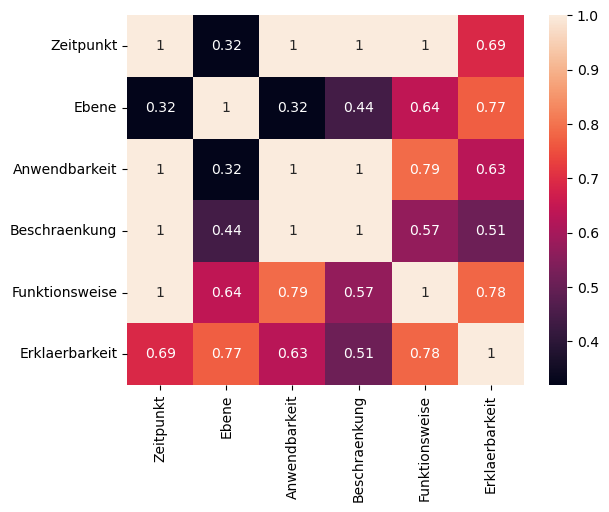

In [18]:
data = np.random.randint(low=1, high=100, size=(10, 10))  
hm = sns.heatmap(data=cramers_v_values, annot=True)
plt.show()

&emsp;

&emsp;

**Berechnen der Summen der Cramers Vs für alle Features**

Hieraus kann abgeleitet werden, welche Features die stärskten Korrelationen aufweisen.

In [19]:
def cvSums(frame):
    features = list(frame)
    sums = []
    for feature in features:
        sums.append(np.sum(cramers_v_values[feature].array))
    return sums

In [23]:
sums = cvSums(xai_features)
sums_normalized = normalize(sums)
feature_correlation_sums = pd.DataFrame(data=[list(xai_features),sums, sums_normalized]).T

feature_correlation_sums.columns=['Merkmal','Cramers V-Summe', 'Cramers V-Summe (normiert)']
feature_correlation_sums.sort_values(by=['Cramers V-Summe'], inplace=True, ascending=False)
feature_correlation_sums

,Merkmal,Cramers V-Summe,Cramers V-Summe (normiert)
0,Zeitpunkt,5.01,1.0
4,Funktionsweise,4.78,0.848684
2,Anwendbarkeit,4.74,0.822368
3,Beschraenkung,4.52,0.677632
5,Erklaerbarkeit,4.38,0.585526
1,Ebene,3.49,0.0


&emsp;

&emsp;

**Finden der optimalen Anordnung**

Nun soll die optimale Reihenfolge der Features für die Taxonomie gefunden werden.
Hierfür werden den eizelnen Features Punkte zugeschrieben.

In [24]:
def calcPoints(features):
    points = []
    for x in features:
        point = calcPoint(x)
        points.append(point)
    return points

def calcPoint(feature):
    p1 = np.array(feature_correlation_sums[feature_correlation_sums['Merkmal']==feature])[0][2]
    p2 = 1 - np.array(feature_values[feature_values['Merkmal']==feature])[0][3]
    point = (p1 + p2) / 2
    return [feature, p1, p2, point]

In [25]:
points = calcPoints(list(xai_features))
feature_points = pd.DataFrame(points, columns =['Merkmal', 'p1', 'p1', 'Punkte'])
feature_points.sort_values(by=['Punkte'], inplace=True, ascending=False)
feature_points

,Merkmal,p1,p1,Punkte
0,Zeitpunkt,1.000000,1.000000,1.000000
2,Anwendbarkeit,0.822368,1.000000,0.911184
1,Ebene,0.000000,1.000000,0.500000
4,Funktionsweise,0.848684,0.000000,0.424342
3,Beschraenkung,0.677632,0.166667,0.422149
5,Erklaerbarkeit,0.585526,0.166667,0.376096
